In [2]:
import goes2go
import pandas as pd
import numpy as np
import xarray as xr
from goes2go import GOES
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

import fsspec
fs = fsspec.filesystem('s3', anon=True)
fsspec_caching = {
    "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
    "block_size": 8
    * 1024
    * 1024,  # size in bytes per block, adjust depends on the file size but the recommended size is in the MB
}

#### Find all files between launch of satellite and now

We need to write a loop around this, since the goes2go searching across long time periods is pretty slow. I also noticed that `goes2go.goes_nearesttime` takes way longer than searching for a timerange.

In [5]:
abi_files = goes2go.goes_timerange(
    start=datetime(2018, 2, 1, 10, 00), 
    end=datetime(2018, 2, 1, 11, 00),
    download=False,
    domain='F',
    product="ABI-L2-CMIP",
    bands=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
)

In [6]:
abi_files

,file,product_mode,satellite,start,end,creation,product,mode_bands,mode,band
0,noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2...,ABI-L2-CMIPF-M3C01,G16,2018-02-01 10:00:45.300,2018-02-01 10:11:22.000,2018-02-01 10:11:28.900,ABI-L2-CMIPF,M3C01,3,1
1,noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2...,ABI-L2-CMIPF-M3C01,G16,2018-02-01 10:15:45.300,2018-02-01 10:26:22.000,2018-02-01 10:26:29.100,ABI-L2-CMIPF,M3C01,3,1
2,noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2...,ABI-L2-CMIPF-M3C01,G16,2018-02-01 10:30:45.300,2018-02-01 10:41:22.000,2018-02-01 10:41:29.500,ABI-L2-CMIPF,M3C01,3,1
3,noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2...,ABI-L2-CMIPF-M3C01,G16,2018-02-01 10:45:45.300,2018-02-01 10:56:22.000,2018-02-01 10:56:29.300,ABI-L2-CMIPF,M3C01,3,1
4,noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2...,ABI-L2-CMIPF-M3C02,G16,2018-02-01 10:00:45.300,2018-02-01 10:11:22.000,2018-02-01 10:11:29.000,ABI-L2-CMIPF,M3C02,3,2
...,...,...,...,...,...,...,...,...,...,...
59,noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2...,ABI-L2-CMIPF-M3C15,G16,2018-02-01 10:45:45.300,2018-02-01 10:56:22.500,2018-02-01 10:56:30.800,ABI-L2-CMIPF,M3C15,3,15
60,noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2...,ABI-L2-CMIPF-M3C16,G16,2018-02-01 10:00:45.300,2018-02-01 10:11:23.100,2018-02-01 10:11:30.600,ABI-L2-CMIPF,M3C16,3,16
61,noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2...,ABI-L2-CMIPF-M3C16,G16,2018-02-01 10:15:45.300,2018-02-01 10:26:23.200,2018-02-01 10:26:30.400,ABI-L2-CMIPF,M3C16,3,16
62,noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2...,ABI-L2-CMIPF-M3C16,G16,2018-02-01 10:30:45.300,2018-02-01 10:41:23.100,2018-02-01 10:41:30.800,ABI-L2-CMIPF,M3C16,3,16


#### Compile each channel into a separate DataFrame

In [7]:
channel_list = [
    abi_files[abi_files.product_mode == f"ABI-L2-CMIPF-M3C{ch:02d}"].reset_index(drop=True)
    for ch in range(1, 17)
]

#### Find common start times to filter our examples where some channels are missing

In [8]:
# Get the set of 'start' times for each DataFrame
start_sets = [set(df['start']) for df in channel_list]

# Find the intersection of all sets (start times present in all channels)
common_starts = set.intersection(*start_sets)

# Now, filter each DataFrame to only keep rows with these common start times
channel_list_common = [
    df[df['start'].isin(common_starts)].reset_index(drop=True)
    for df in channel_list
]

In [9]:
unique_starts = list(abi_files['start'].unique())

In [10]:
time_idx = 0
selected_files = [channel_list_common[ch]['file'][time_idx] for ch in range(16)]
sorted(selected_files)

['noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2-CMIPF-M3C01_G16_s20180321000453_e20180321011220_c20180321011289.nc',
 'noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2-CMIPF-M3C02_G16_s20180321000453_e20180321011220_c20180321011290.nc',
 'noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2-CMIPF-M3C03_G16_s20180321000453_e20180321011220_c20180321011291.nc',
 'noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2-CMIPF-M3C04_G16_s20180321000453_e20180321011220_c20180321011283.nc',
 'noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2-CMIPF-M3C05_G16_s20180321000453_e20180321011220_c20180321011289.nc',
 'noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2-CMIPF-M3C06_G16_s20180321000453_e20180321011225_c20180321011283.nc',
 'noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2-CMIPF-M3C07_G16_s20180321000453_e20180321011231_c20180321011291.nc',
 'noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2-CMIPF-M3C08_G16_s20180321000453_e20180321011220_c20180321011288.nc',
 'noaa-goes16/ABI-L2-CMIPF/2018/032/10/OR_ABI-L2-CMIPF-M

#### Open example file

Notes on Channel Resolution:

- 0.64 um visible (channel 2) = 0.5 km 
- Other visible/NIR = 1 km
- Bands (>2 um) = 2 km

In [11]:
index = 0
channel = 14
goes_data = xr.open_dataset(fs.open(channel_list_common[channel]['file'][index], **fsspec_caching), engine="h5netcdf")

In [51]:
goes_data

<xarray.Dataset>
Dimensions:                                 (y: 10848, x: 10848,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float64 0.1519 ... -0.1519
  * x                                       (x) float64 -0.1519 ... 0.1519
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_id                                 (band) int8 ...
    band_wavelength                         (band) float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/29)
    CMI                                     (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  int32 ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    ...                                      ...
    algorithm_dynamic_input_data_container  int32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    earth_sun_distance_anomaly_in_AU        float32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2018-02-01T10:00:45.3Z
    time_coverage_end:         2018-02-01T10:11:22.0Z
    timeline_id:               ABI Mode 3
    production_data_source:    Realtime
    id:                        2d21b69d-4b07-490c-8d8d-bbf208e5c88f

In [ ]:
goes_data.CMI.plot()

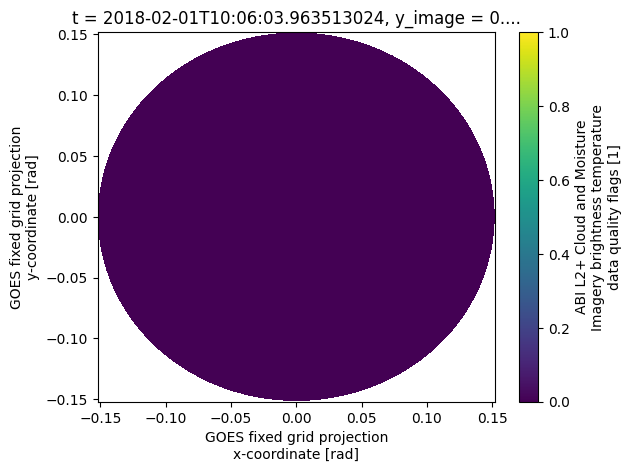

In [9]:
goes_data.DQF.plot()

In [ ]:
def preprocess(ds: xr.Dataset) -> xr.Dataset:
        """
        Preprocesses the GOES16 radiance dataset.

        Args:
            ds (xr.Dataset): The input dataset.
            calc_coords (bool): Whether to calculate latitude and longitude coordinates. Defaults to False.

        Returns:
            xr.Dataset: The preprocessed dataset.
        """
        # TODO: What variables do we want to keep?
        variables = ["CMI", "DQF"] # "Rad" = radiance, "DQF" = data quality flag

        # Extract relevant attributes from original dataset
        time_stamp = pd.to_datetime(ds.t.values) 
        band_wavelength_attributes = ds.band_wavelength.attrs
        band_wavelength_values = ds.band_wavelength.values
        band_attributes = ds.band_id.attrs
        band_values = ds.band_id.values

        # do core preprocess function (e.g. to correct band coordinates, subset data, resample, etc.)
        # ds_subset = preprocess_fn(ds, calc_coords=calc_coords)
        # TODO: Add cropping and resampling 
        ds_subset = ds

        # convert measurement time (in seconds) to datetime
        time_stamp = time_stamp.strftime("%Y-%m-%d %H:%M") 
        # assign bands data to each variable
        ds_subset = ds_subset[variables]
        ds_subset = ds_subset.expand_dims({"band": band_values})
        # attach time coordinate
        ds_subset = ds_subset.assign_coords({"time": [time_stamp]})
        # drop variables that will no longer be needed
        ds_subset = ds_subset.drop_vars(["t", "y_image", "x_image"])
        # assign band attributes to dataset
        ds_subset.band.attrs = band_attributes
        # assign band wavelength to each variable
        ds_subset = ds_subset.assign_coords({"band_wavelength": band_wavelength_values})
        ds_subset.band_wavelength.attrs = band_wavelength_attributes
        return ds_subset

In [85]:
goes_preprocessed = preprocess(goes_data)

In [86]:
goes_preprocessed

<xarray.Dataset>
Dimensions:          (band: 1, y: 5424, x: 5424, time: 1, band_wavelength: 1)
Coordinates:
  * band             (band) int32 15
  * y                (y) float64 0.1518 0.1518 0.1517 ... -0.1518 -0.1518
  * x                (x) float64 -0.1518 -0.1518 -0.1517 ... 0.1518 0.1518
  * time             (time) <U16 '2018-02-01 10:06'
  * band_wavelength  (band_wavelength) float32 12.27
Data variables:
    CMI              (band, y, x) float32 nan nan nan nan ... nan nan nan nan
    DQF              (band, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2018-02-01T10:00:45.3Z
    time_coverage_end:         2018-02-01T10:11:22.5Z
    timeline_id:               ABI Mode 3
    production_data_source:    Realtime
    id:                        3e06d055-3c58-4262-b6d4-14975f499003

In [99]:
# Simpler caching setup
fsspec_caching_simple = {
    "cache_type": "none"  # Disable caching temporarily
}

# Open multiple files as file-like objects
test_files = selected_files[-4:]
file_objects = [fs.open(file, **fsspec_caching_simple) for file in test_files]

In [ ]:
# Use xarray to open all at once
ds = xr.open_mfdataset(
    file_objects, 
    preprocess=preprocess,
    concat_dim="band",
    engine="h5netcdf",
    combine='nested'
)

#### Create sub-patch from full-disk

- Mask percentage of full disk
- Sample with bias towards the center

In [21]:
def create_fov_mask(shape, fov_radius, patch_shape=None):
    """
    Function to create mask for specified field of view.
    """
    # Create coordinate grids
    y, x = np.ogrid[:shape[0], :shape[1]]
    # Calculate center points
    center_y, center_x = shape[0] // 2, shape[1] // 2
    # Calculate distance from center for each point
    dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    # Normalize distances by max possible distance (corner to center)
    max_dist = np.sqrt((center_x)**2 + (center_y)**2)
    normalized_dist = dist_from_center / max_dist
    # Create mask for specified field of view
    mask = normalized_dist <= fov_radius

    # If specified, ensure the mask also covers the patch size
    if patch_shape is not None:
        patch_shape_half_x = patch_shape[0] // 2 + 1
        patch_shape_half_y = patch_shape[1] // 2 + 1
        # Create a square mask for the patch size
        patch_mask = np.ones(shape, dtype=bool)
        # Mask out the corner area to keep everything beyond patch_size_half
        patch_mask[:patch_shape_half_x, :] = False
        patch_mask[-patch_shape_half_x:, :] = False
        patch_mask[:, :patch_shape_half_y] = False
        patch_mask[:, -patch_shape_half_y:] = False
        # Combine the two masks
        mask = mask & patch_mask
    return mask

##### Steps Explained:

In [17]:
# Some steps explained:
# 1. We first create an x/y meshgrid of the datasets
x_grid, y_grid = np.meshgrid(np.arange(0, goes_data.x.shape[0], 1), np.arange(0, goes_data.y.shape[0], 1))
x_grid, y_grid

(array([[   0,    1,    2, ..., 5421, 5422, 5423],
        [   0,    1,    2, ..., 5421, 5422, 5423],
        [   0,    1,    2, ..., 5421, 5422, 5423],
        ...,
        [   0,    1,    2, ..., 5421, 5422, 5423],
        [   0,    1,    2, ..., 5421, 5422, 5423],
        [   0,    1,    2, ..., 5421, 5422, 5423]]),
 array([[   0,    0,    0, ...,    0,    0,    0],
        [   1,    1,    1, ...,    1,    1,    1],
        [   2,    2,    2, ...,    2,    2,    2],
        ...,
        [5421, 5421, 5421, ..., 5421, 5421, 5421],
        [5422, 5422, 5422, ..., 5422, 5422, 5422],
        [5423, 5423, 5423, ..., 5423, 5423, 5423]]))

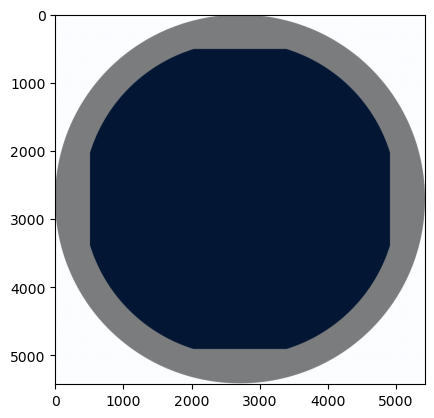

In [22]:
# 2. We then create mask for valid coordinates within desired field of view
# NOTE: This masks from the center to the image edge, rather than disk edge
valid_mask = create_fov_mask(shape=(goes_data.x.shape[0], goes_data.y.shape[0]), fov_radius=0.6, patch_shape=(1024, 1024))

plt.imshow(goes_data.DQF.values, cmap='gray')
plt.imshow(valid_mask, alpha=0.5, cmap='Blues')

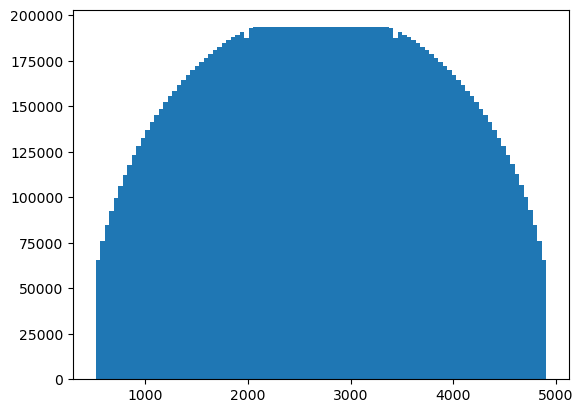

In [23]:
# 3. get coordinate pairs for valid points
coords_on_disk = np.column_stack((x_grid[valid_mask], y_grid[valid_mask]))

plt.hist(coords_on_disk[:, 0], bins=100);
# This creates a bias of coordates towards the center of the image, that we can sample from

In [24]:
class CenterWeightedCropDatasetEditor():
    def __init__(self, patch_shape, data_key='Rad', fov_radius=0.6):
        self.patch_shape = patch_shape
        self.data_key = data_key
        self.fov_radius = fov_radius
        self.max_attempts = 5
    def __call__(self, ds):
        assert ds['x'].shape[0] >= self.patch_shape[0], 'Invalid dataset shape: %s' % str(ds['x'].shape)
        assert ds['y'].shape[0] >= self.patch_shape[1], 'Invalid dataset shape: %s' % str(ds['y'].shape)

        # create an x/y meshgrid of the datasets
        x_grid, y_grid = np.meshgrid(np.arange(0, ds.x.shape[0], 1), np.arange(0, ds.y.shape[0], 1))

        # create mask for valid coordinates within desired field of view
        # NOTE: This masks from the center to the image edge, rather than disk edge
        valid_mask = create_fov_mask(shape=(ds.x.shape[0], ds.y.shape[0]), fov_radius=self.fov_radius, patch_shape=self.patch_shape)

        # get coordinate pairs for valid points
        coords_on_disk = np.column_stack((x_grid[valid_mask], y_grid[valid_mask]))
        del x_grid, y_grid

        random_idx = np.random.randint(0, len(coords_on_disk))
        x, y = tuple(coords_on_disk[random_idx])
        # define patch boundaries
        xmin = x - self.patch_shape[0] // 2
        ymin = y - self.patch_shape[1] // 2
        xmax = x + self.patch_shape[0] // 2
        ymax = y + self.patch_shape[1] // 2

        # crop patch
        patch_ds = ds.sel({'x': slice(ds['x'][xmin], ds['x'][xmax - 1]),
                            'y': slice(ds['y'][ymin], ds['y'][ymax - 1])})
        
        # TODO: Add check for data quality
        return patch_ds, xmin, ymin

In [ ]:
# create mask for valid coordinates within desired field of view
# NOTE: This masks from the center to the image edge, rather than disk edge
valid_mask = create_fov_mask(shape=(ds.x.shape[0], ds.y.shape[0]), fov_radius=0.6, patch_shape=(1024, 1024))

# get coordinate pairs for valid points
coords_on_disk = np.column_stack((x_grid[valid_mask], y_grid[valid_mask]))

In [104]:
patch_size = 1024

crop = CenterWeightedCropDatasetEditor(patch_shape=(patch_size, patch_size), data_key='CMI', fov_radius=0.6)
patch_ds, xmin, ymin = crop(ds)

In [111]:
patch_ds.CMI

<xarray.DataArray 'CMI' (band: 4, y: 1024, x: 1024)>
dask.array<getitem, shape=(4, 1024, 1024), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 0.09187 0.09181 0.09176 ... 0.03469 0.03464 0.03458
  * x        (x) float64 0.06964 0.06969 0.06975 0.0698 ... 0.1268 0.1269 0.1269
  * band     (band) int32 13 14 15 16
Attributes:
    long_name:              ABI L2+ Cloud and Moisture Imagery brightness tem...
    standard_name:          toa_brightness_temperature
    sensor_band_bit_depth:  12
    valid_range:            [   0 4095]
    units:                  K
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

Next Steps:

- Rename variables
- Load other channels
- Interpolate / crop them to the same grid


Questions:
- What resolution do we want to pick as an "anchor"?
- Any additional metadata/variables to pass through?
- How do we best handle the quality flags of the different channels?
- Can we keep the format of our data from last year? i.e. the same naming conventions?
- Maybe prepping 50,000 samples was too ambitious? Shall we focus on less?